In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import os
import matplotlib.pyplot as plt

2022-11-21 10:09:54.692360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paths for trains and test images:
train = './data/dino-dragon/train/'
test = './data/dino-dragon/test/'

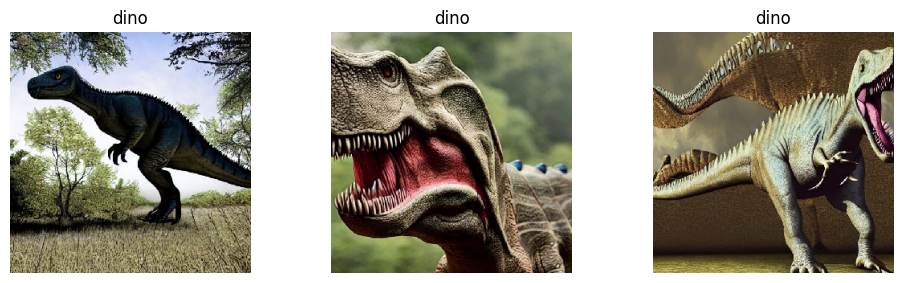

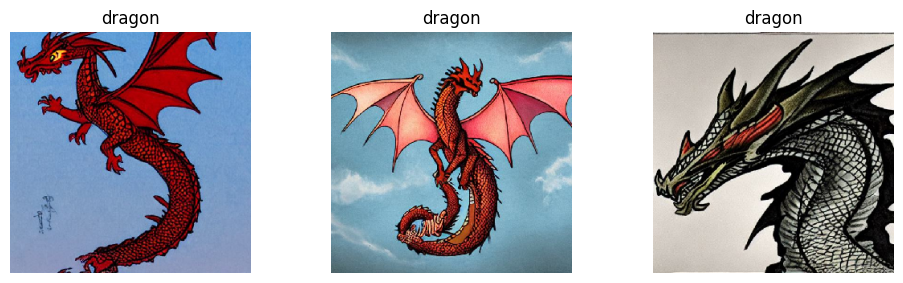

In [3]:
def show_images(n):
    '''
    Function for showing images in row per class
    '''
    classes =['dino', 'dragon']
    for c in classes:
        # label subplots with class name:
        fig, ax = plt.subplots(1, n, figsize=(10,3), sharey=True)
        fig.tight_layout()
        for i in range(n):    
            # define file name:
            filepath = os.path.join(train + c + '/' + os.listdir(train + c)[i])

            # load image
            img = load_img(filepath, target_size=(300, 300))

            # show image:
            ax[i].imshow(img)
            ax[i].set_title(c)
            ax[i].axis('off')
    
show_images(3)

### Pretrained convolutional neural netrwork:

In [4]:
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions


model = Xception(weights='imagenet', input_shape=(299, 299, 3))




2022-11-21 10:10:04.047306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import numpy as np
img_path = os.path.join(train + 'dino' + '/' + os.listdir(train + 'dino')[0])
img = load_img(img_path, target_size=(299,299))
x = np.array(img)
x.shape

(299, 299, 3)

In [6]:
# Creating batch
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [7]:
# preprocess input:
X = preprocess_input(X)

In [8]:
pred = model.predict(X)

1/1 [==============================] - 1s 743ms/step


In [9]:
decode_predictions(pred)

[[('n01704323', 'triceratops', 0.41432106),
  ('n01677366', 'common_iguana', 0.3715633),
  ('n01694178', 'African_chameleon', 0.08958301),
  ('n01695060', 'Komodo_dragon', 0.009834861),
  ('n01675722', 'banded_gecko', 0.0037982145)]]

### Transfer learning:

In [5]:
# read data with imagedatagenerator:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(train, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 1594 images belonging to 2 classes.


In [6]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [7]:
X, y = next(train_ds)

In [8]:
y.shape

(32,)

In [9]:
# validation data generation

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(test, target_size=(150, 150), batch_size=32, shuffle=False, class_mode='binary')

Found 394 images belonging to 2 classes.


In [15]:
# Base model:
# include_top=False meaning don't include the top dense layer
base_model = Xception(include_top=False, weights = 'imagenet', input_shape=(150, 150, 3))

# trainable=False meaning don't train the conv layer, only extract the vectors
base_model.trainable = False

In [16]:
# Arch
# Create new TOP Dense layer with our data:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(2)(vectors)

model = keras.Model(inputs, outputs)

In [17]:
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Logits=true meaning take raw score without using activation function.
loss = keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [18]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds )

Epoch 1/10
50/50 [==============================] - 37s 702ms/step - loss: 0.1232 - accuracy: 0.9555 - val_loss: 0.0363 - val_accuracy: 0.9848
Epoch 2/10
50/50 [==============================] - 37s 736ms/step - loss: 0.0181 - accuracy: 0.9925 - val_loss: 0.0474 - val_accuracy: 0.9873
Epoch 3/10
50/50 [==============================] - 37s 737ms/step - loss: 0.0084 - accuracy: 0.9987 - val_loss: 0.0353 - val_accuracy: 0.9873
Epoch 4/10
50/50 [==============================] - 37s 741ms/step - loss: 0.0063 - accuracy: 0.9994 - val_loss: 0.0408 - val_accuracy: 0.9873
Epoch 5/10
50/50 [==============================] - 37s 750ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 0.9873
Epoch 6/10
50/50 [==============================] - 38s 756ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9873
Epoch 7/10
50/50 [==============================] - 38s 758ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.9873

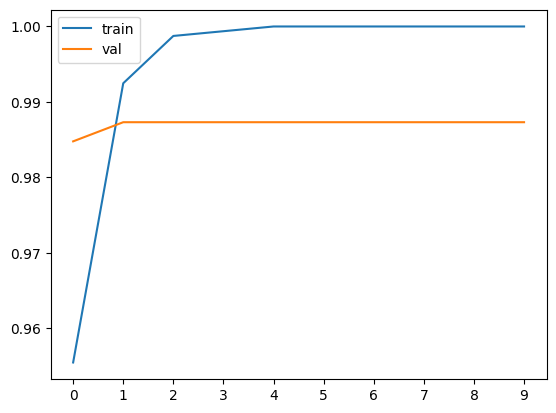

In [30]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

### Checkpoint

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(
            './models/xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max')

In [36]:
def make_model(learning_rate, epochs):
    # Base model:
    # include_top=False meaning don't include the top dense layer
    base_model = Xception(include_top=False, weights = 'imagenet', input_shape=(150, 150, 3))

    # trainable=False meaning don't train the conv layer, only extract the vectors
    base_model.trainable = False

    ################# Arch ##################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.
    outputs = keras.layers.Dense(2)(vectors)
    model = keras.Model(inputs, outputs)
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Logits=true meaning take raw score without using activation function.
    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model
    
learning_rate = 0.01
epochs = 5
    
model = make_model(learning_rate, epochs)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/5
50/50 [==============================] - 32s 607ms/step - loss: 0.0876 - accuracy: 0.9743 - val_loss: 0.0320 - val_accuracy: 0.9873
Epoch 2/5
50/50 [==============================] - 34s 689ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0367 - val_accuracy: 0.9848
Epoch 3/5
50/50 [==============================] - 33s 662ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.0340 - val_accuracy: 0.9898
Epoch 4/5
50/50 [==============================] - 31s 626ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 0.9873
Epoch 5/5
50/50 [==============================] - 29s 582ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.9873


## Regularization & Dropout with large image shapes

In [13]:
# read data with imagedatagenerator:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 299

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(train, target_size=(img_size, img_size), batch_size=32, class_mode='binary')

def make_model(learning_rate, epochs):
    # Base model:
    # include_top=False meaning don't include the top dense layer
    base_model = Xception(include_top=False, weights = 'imagenet', input_shape=(img_size, img_size, 3))

    # trainable=False meaning don't train the conv layer, only extract the vectors
    base_model.trainable = False

    ################# Arch ##################
    inputs = keras.Input(shape=(img_size, img_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(100, activation='relu')(vectors)
    drop = keras.layers.Dropout(0.5)
    outputs = keras.layers.Dense(1, activation='sigmoid')(inner)
    model = keras.Model(inputs, outputs)
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Logits=true meaning take raw score without using activation function.
    loss = keras.losses.BinaryCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model
    
learning_rate = 0.01
epochs = 5
    
model = make_model(learning_rate, epochs)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint])

Found 1594 images belonging to 2 classes.
Epoch 1/5
50/50 [==============================] - 163s 3s/step - loss: 0.1004 - accuracy: 0.9718 - val_loss: 0.3528 - val_accuracy: 0.9721
Epoch 2/5
50/50 [==============================] - 169s 3s/step - loss: 0.0234 - accuracy: 0.9937 - val_loss: 0.5702 - val_accuracy: 0.9543
Epoch 3/5
50/50 [==============================] - 133s 3s/step - loss: 0.0063 - accuracy: 0.9956 - val_loss: 0.1207 - val_accuracy: 0.9873
Epoch 4/5
50/50 [==============================] - 120s 2s/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.1406 - val_accuracy: 0.9848
Epoch 5/5
50/50 [==============================] - 118s 2s/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.1109 - val_accuracy: 0.9873


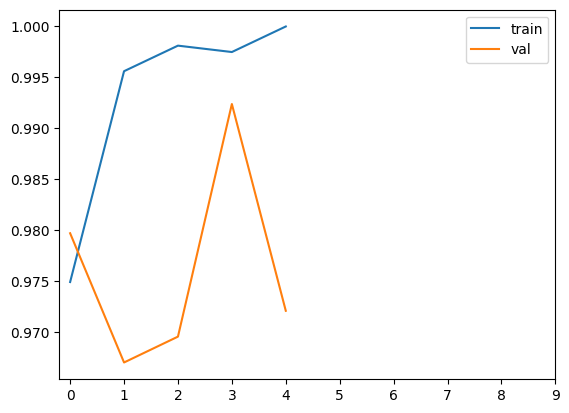

In [60]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

# Use Model:

* Loading the model
* Getting the prediction

In [14]:
import tensorflow as tf
from tensorflow import keras

In [15]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

In [73]:
test_path = './data/dino-dragon/test/'

In [44]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(test_path, 
                                       target_size=(299, 299), 
                                       batch_size=32, 
                                       shuffle=False
                                      )
    

    

Found 394 images belonging to 2 classes.


In [17]:
# load model
model = keras.models.load_model('./models/xception_v1_03_0.987.h5')

In [62]:
# evaluate model:
model.evaluate(test_ds)

13/13 [==============================] - 25s 2s/step - loss: 0.0170 - accuracy: 0.9924


[0.01703750714659691, 0.9923858046531677]

In [18]:
sample_image = './data/dino-dragon/test/dino/001db8b8-33ff-44b3-8f50-325f4ab4f713.jpg'

img = load_img(sample_image, target_size=(img_size, img_size))

In [19]:
# converting single image to proper shape
import numpy as np

x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [20]:
X = preprocess_input(X)
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [21]:
pred

array([[1.6953327e-09]], dtype=float32)

In [27]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [34]:
img_path = './data/dino-dragon/test/dragon/0257fcb6-cd56-4fe4-b894-935111f4f48e.jpg'
def predict_single(img_path):
    sample_image = img_path
    img = load_img(sample_image, target_size=(img_size, img_size))
    
    import numpy as np

    x = np.array(img)
    X = np.array([x])
    
    if pred[0][0] > 0.5:
        return 'Dragon'
    else:
        return 'Dino'

predict_single(img_path)

'Dino'

In [36]:
pred

array([[1.6953327e-09]], dtype=float32)

Dino
